# Binary Classification (Adult Dataset)

In this example, we analyze different binary classifiers and quantify various explainable aspects across four models. Aspects such as PD fluctuation, ranking consistency, importance stability, and feature concentration are explored to provide insights into how these models handle their output decisions.

In [ ]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from holisticai.utils import BinaryClassificationProxy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from holisticai.datasets import load_dataset
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from holisticai.inspection import compute_permutation_importance, compute_shap_feature_importance, compute_partial_dependence
from holisticai.utils import concatenate_metrics
from holisticai.utils.surrogate_models import create_surrogate_model
from holisticai.explainability.plots import plot_feature_importance, plot_explainable_partial_dependence, plot_local_feature_importances_stability, plot_top_explainable_global_feature_importances, plot_ranking_consistency, plot_radar_metrics
from holisticai.utils.data_preprocessor import simple_preprocessor

from holisticai.explainability.metrics.global_feature_importance import classification_global_feature_importance_explainability_metrics
from holisticai.efficacy.metrics import classification_efficacy_metrics

/home/cristian/.local/share/hatch/env/virtual/holisticai/4NjQH6EQ/testing/lib/python3.11/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


load Adult Dataset and traint test splits

In [ ]:
dataset = load_dataset('adult', preprocessed=False)
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
dataset

Make a simple preprocessing for categorical and numerical columns

In [3]:
train = dataset['train']
test = dataset['test']

Xt_train, Xt_test, yt_train, yt_test = simple_preprocessor(train['X'], test['X'], train['y'], test['y'])

Train an compute efficacy Metrics

In [5]:
original_models  = {
    'RandomForestClassifier': RandomForestClassifier(random_state=42), 
    'XGBClassifier':XGBClassifier(random_state=42), 
    'LogisticRegression':LogisticRegression(random_state=64), 
    'MLPClassifier':MLPClassifier(random_state=42)
}

models = {}
metrics = {}
for model_name,model in original_models.items():
    model.fit(Xt_train, yt_train)
    models[model_name] = BinaryClassificationProxy(predict=model.predict, predict_proba=model.predict_proba, classes=model.classes_)

    y_pred_test = model.predict(Xt_test)
    metrics[model_name] = classification_efficacy_metrics(yt_test, y_pred_test)

efficacy_metrics = concatenate_metrics(metrics)
efficacy_metrics

# Global Feature Importance

### Global Feature Importance  - Features

In [ ]:
top_n = 8

results = {}
for model_name,proxy in tqdm(models.items()):
    importances  = compute_permutation_importance(X=Xt_test, y=yt_test, proxy=proxy)
    top_feature_names = list(importances.as_dataframe().sort_values('Importance', ascending=False).head(top_n).Variable)
    conditional_feature_importances  = compute_permutation_importance(X=Xt_test, y=yt_test, proxy=proxy, importance_type="conditional")
    partial_dependencies = compute_partial_dependence(Xt_test, features=top_feature_names[:top_n], proxy=proxy)
    results[model_name] = {
        'importances':importances, 
        'conditional_feature_importances':conditional_feature_importances, 
        'partial_dependencies':partial_dependencies
    }

 25%|██▌       | 1/4 [01:34<04:44, 94.87s/it]/home/cristian/.local/share/hatch/env/virtual/holisticai/4NjQH6EQ/testing/lib/python3.11/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/cristian/.local/share/hatch/env/virtual/holisticai/4NjQH6EQ/testing/lib/python3.11/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a

### Global Feature Importance  - Metrics

In [9]:
metrics = {}
for model_name,result in tqdm(results.items()):
    metrics[model_name] = classification_global_feature_importance_explainability_metrics(result['partial_dependencies'], 
                                                                                                    result['importances'], 
                                                                                                    result['conditional_feature_importances'], 
                                                                                                    top_n=top_n)
global_metrics = concatenate_metrics(metrics)

100%|██████████| 4/4 [00:23<00:00,  5.82s/it]


### Visualization

The function plot_explainable_partial_dependence displays the Partial Dependence Plot (PDP) alongside Individual Conditional Expectation (ICE) curves with the highest fluctuation ratios, effectively highlighting key complexities in a clear and interpretable way. Each subplot title includes the Fluctuation Ratio Score for the respective feature, indicating the average fluctuation across all individuals in the ICE. This score captures fluctuations typically hidden in the average curve and challenging to identify when plotting all individual curves. Additionally, the intensity of the red background quantifies the importance of each feature.

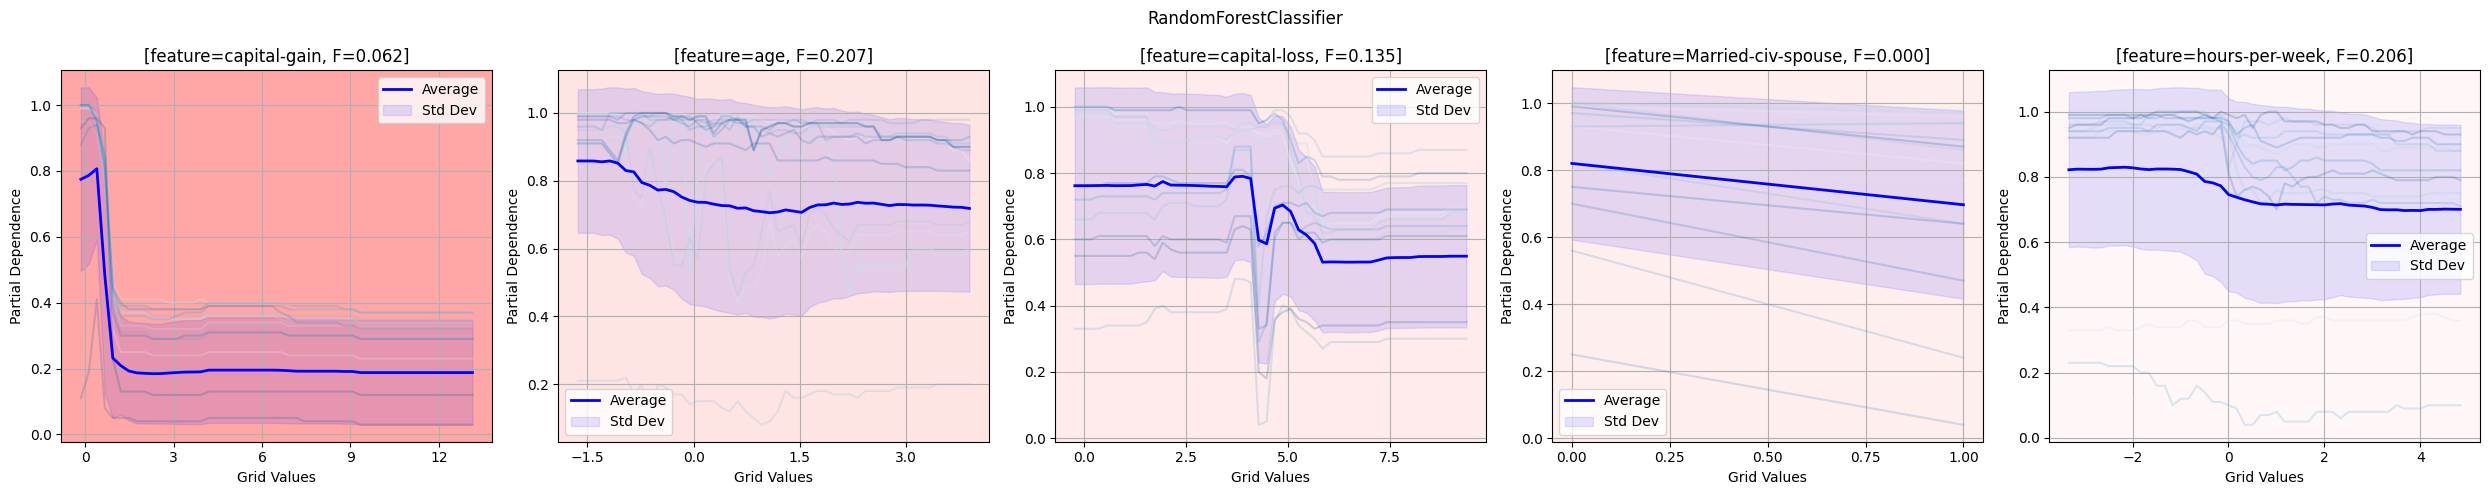

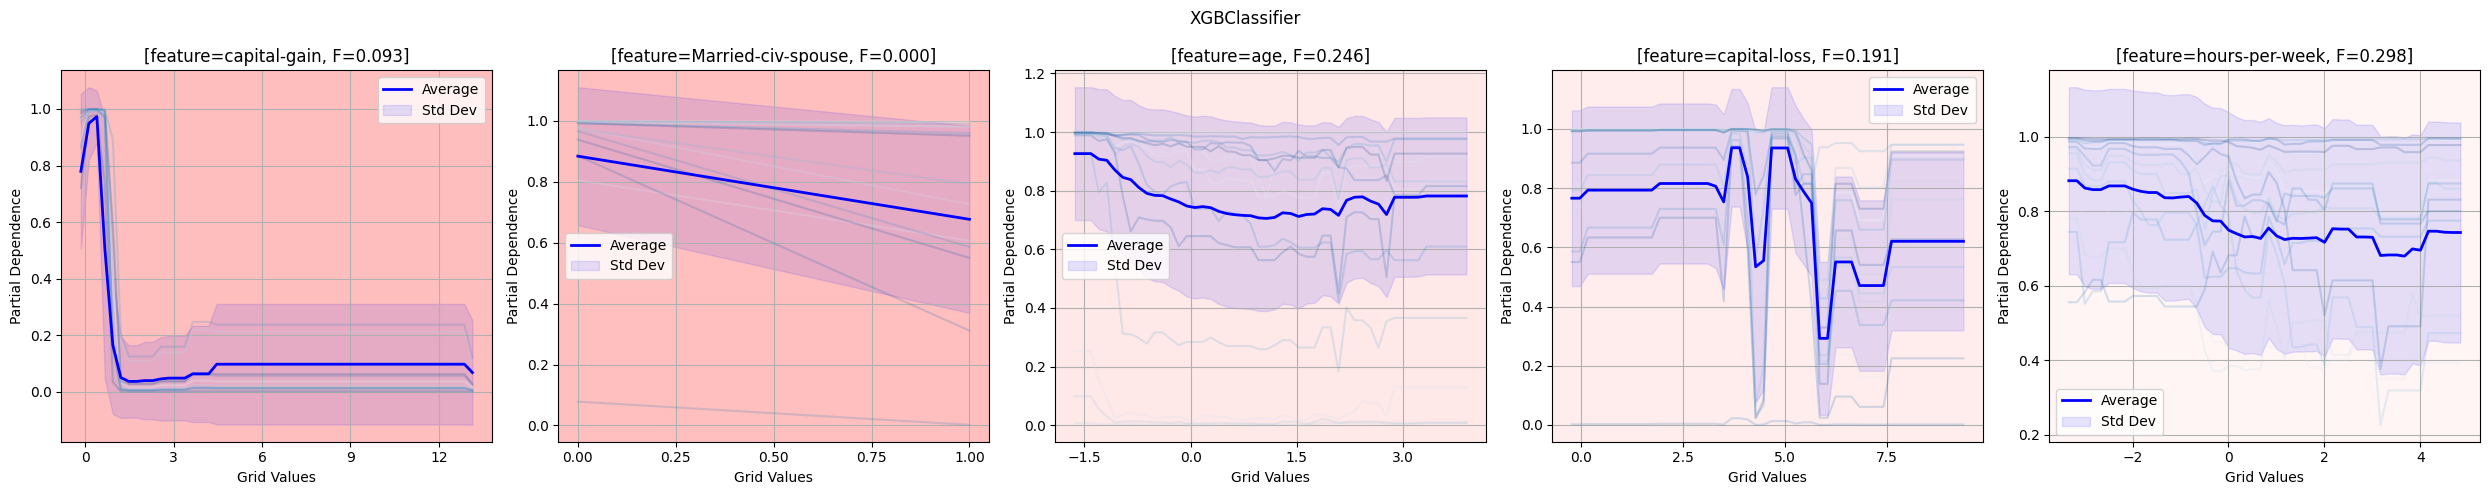

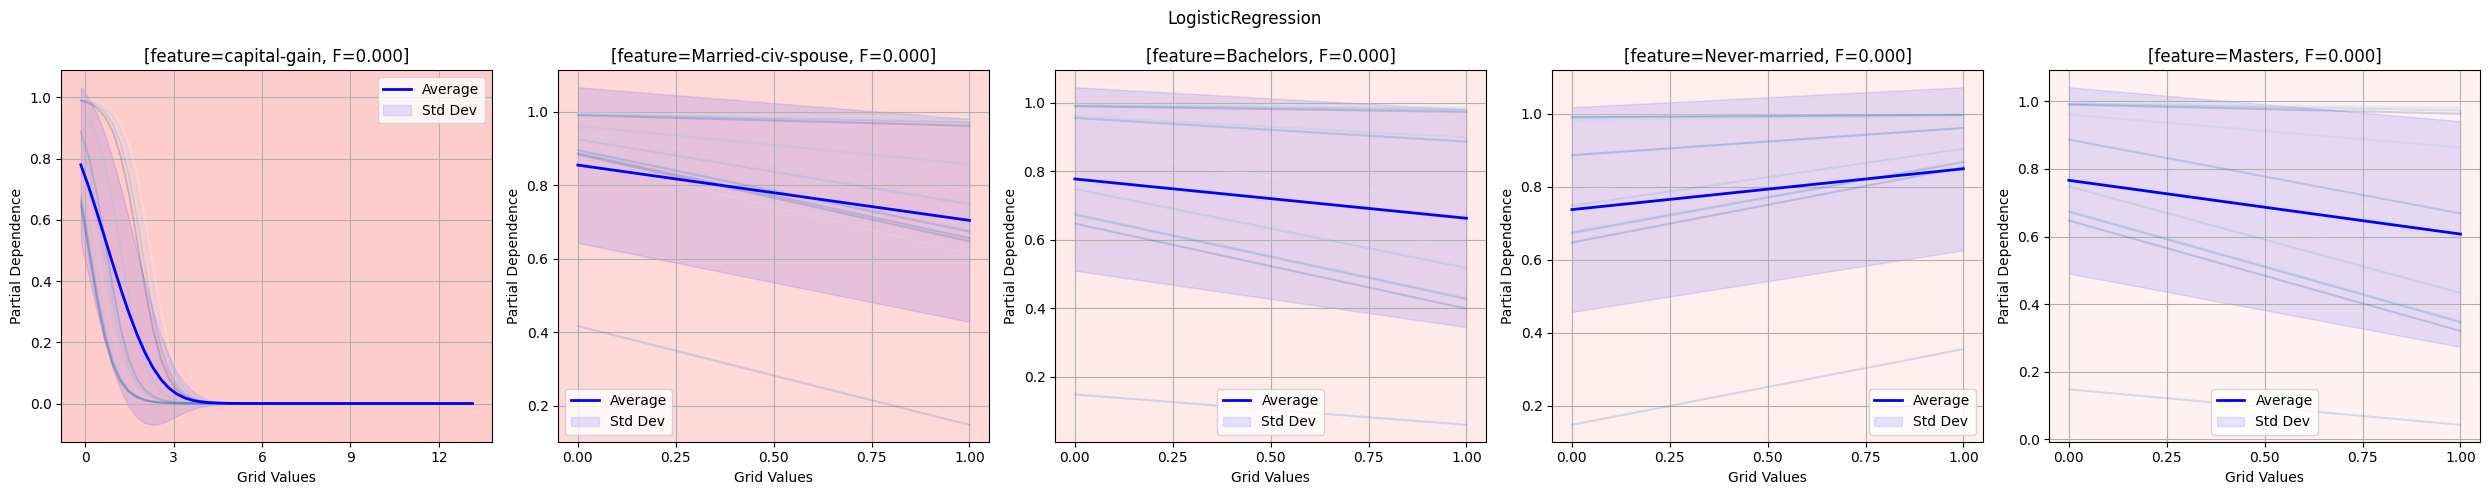

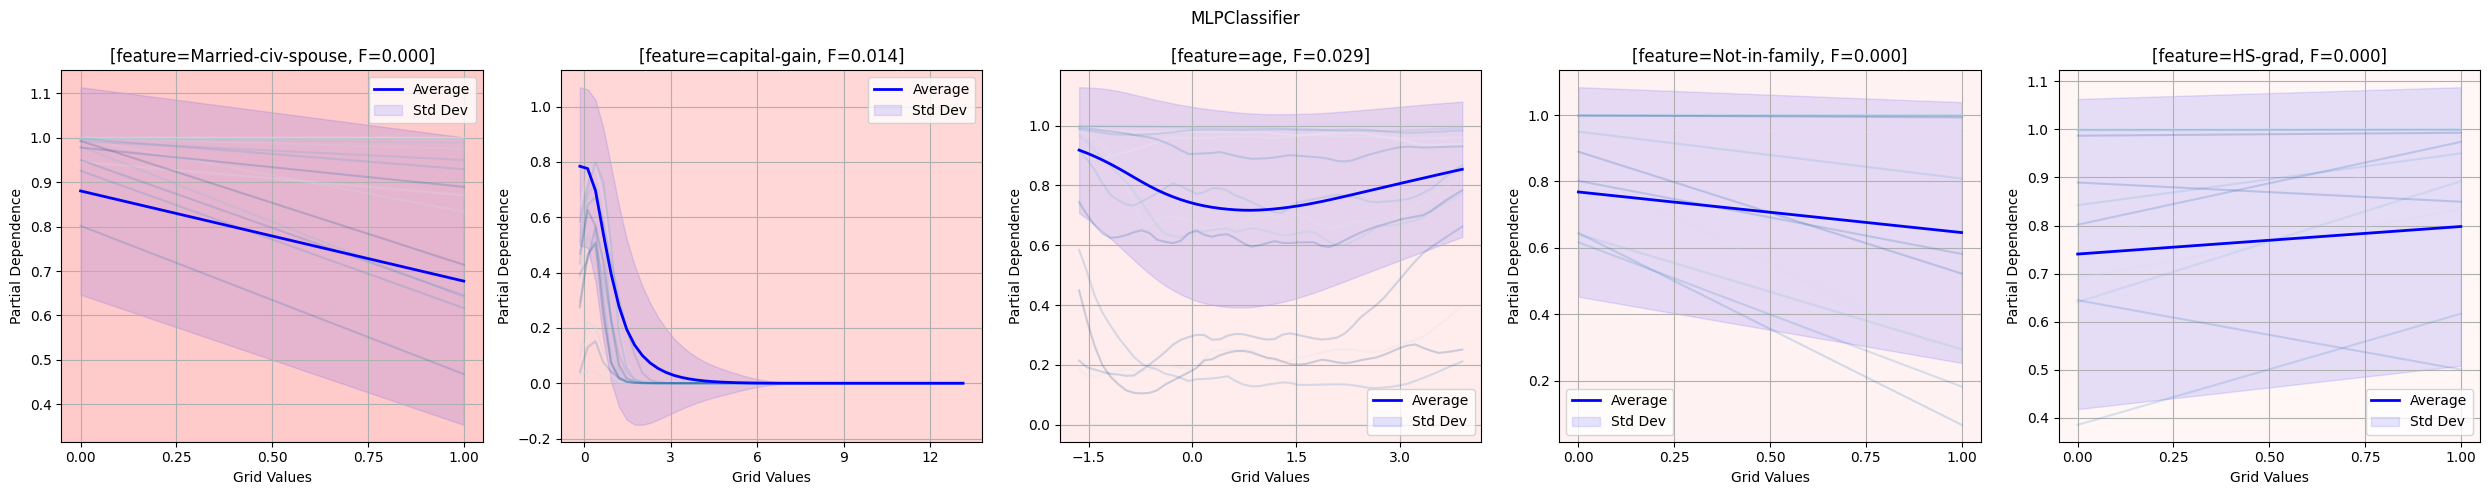

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from scipy.interpolate import interp1d

from holisticai.explainability.metrics.global_feature_importance._fluctuation_ratio import fluctuation_ratio
from holisticai.explainability.metrics.global_feature_importance._xai_ease_score import XAIEaseAnnotator
from holisticai.utils import Importances, PartialDependence

top_n = 5
figsize=(25,5)
for model_name, result in results.items():
    os.makedirs(model_name, exist_ok=True)
    plot_explainable_partial_dependence(result['partial_dependencies'], 
                                        result['importances'], 
                                        figsize=figsize, 
                                        feature_names=result['partial_dependencies'].feature_names, 
                                        model_name=model_name, 
                                        label=1, 
                                        top_n=top_n)
    plt.show()

### Visualization 

Feature Importance  with Fluctuation Ratio

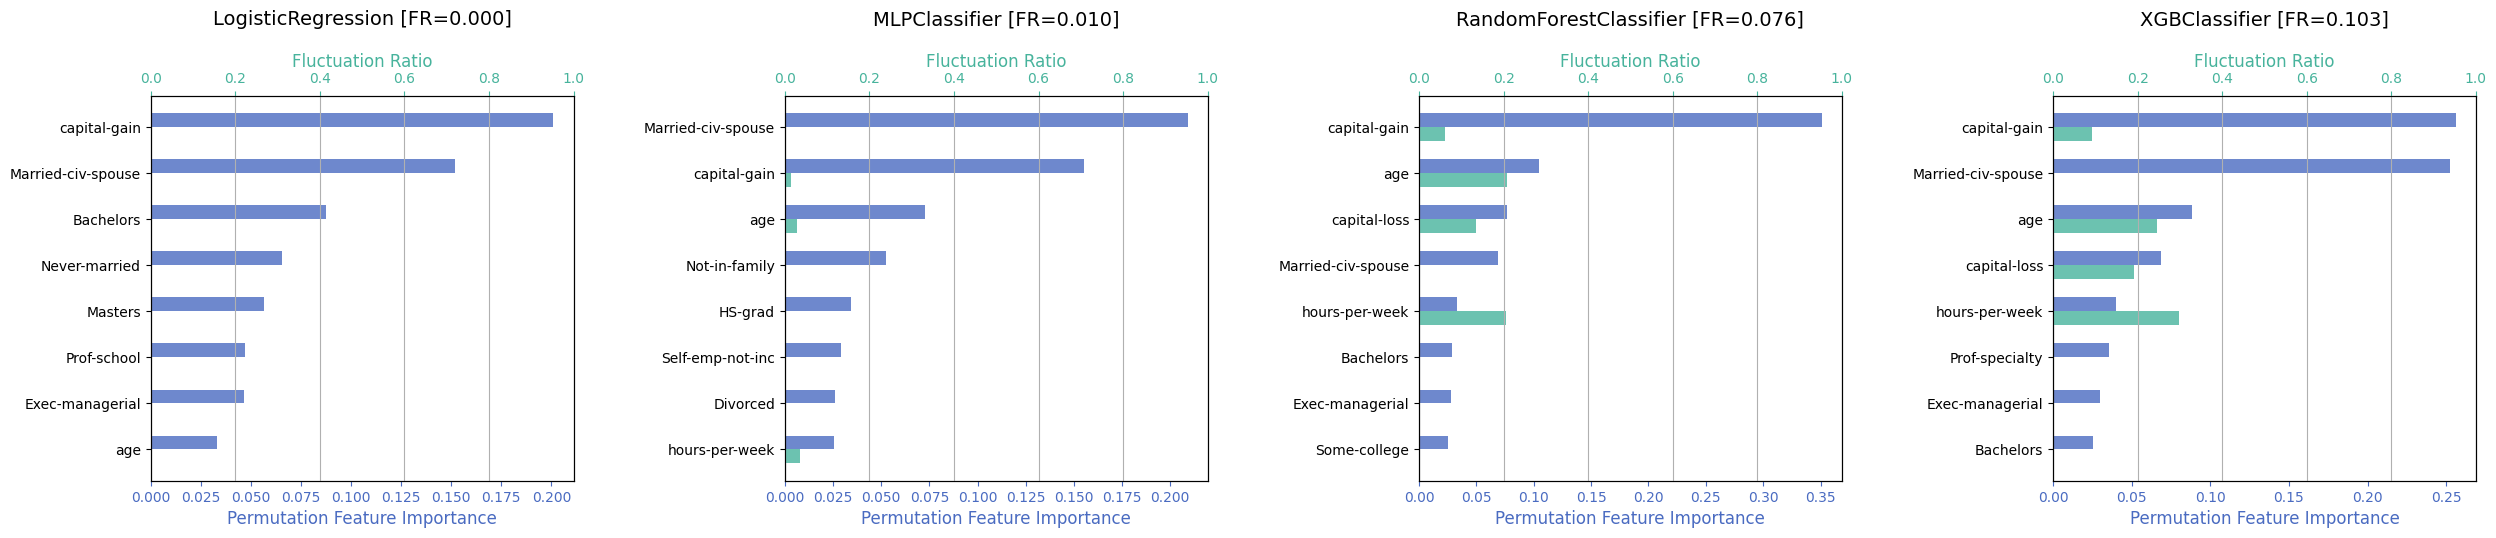

In [26]:
model_names = ['LogisticRegression', 'MLPClassifier', 'RandomForestClassifier', 'XGBClassifier']
top_n=8
plt.figure(figsize=(30, 5))
for i,model_name in enumerate(model_names):
    plt.subplot(1,4,i+1)
    result = results[model_name]
    plot_top_explainable_global_feature_importances(result['partial_dependencies'], result['importances'], model_name, top_n)

# Local Feature Importance

### Local Feature Importance - Features

In [11]:
local_results = {}
for model_name,model in models.items():
    local_importances = compute_shap_feature_importance(X=Xt_train, proxy=model, max_samples=1000, random_state=42)
    local_results[model_name] = {'local_importances':local_importances}

PermutationExplainer explainer: 1001it [02:19,  6.74it/s]                          
PermutationExplainer explainer: 1001it [01:32,  9.66it/s]                          
PermutationExplainer explainer: 1001it [00:10,  6.27it/s]                         
PermutationExplainer explainer: 1001it [01:21,  8.31it/s]                         


### Local Feature Importance - Metrics

In [12]:
from holisticai.explainability.metrics.local_feature_importance import classification_local_feature_importance_explainability_metrics
metrics = {}
for model_name,result in local_results.items():
    metrics[model_name] = classification_local_feature_importance_explainability_metrics(result['local_importances'])

local_metrics = concatenate_metrics(metrics)
local_metrics

,RandomForestClassifier,XGBClassifier,LogisticRegression,MLPClassifier,Reference
Rank Consistency,0.164316,0.174515,0.1672,0.153106,0
Importance Stability,0.09729,0.107428,0.081903,0.068742,0


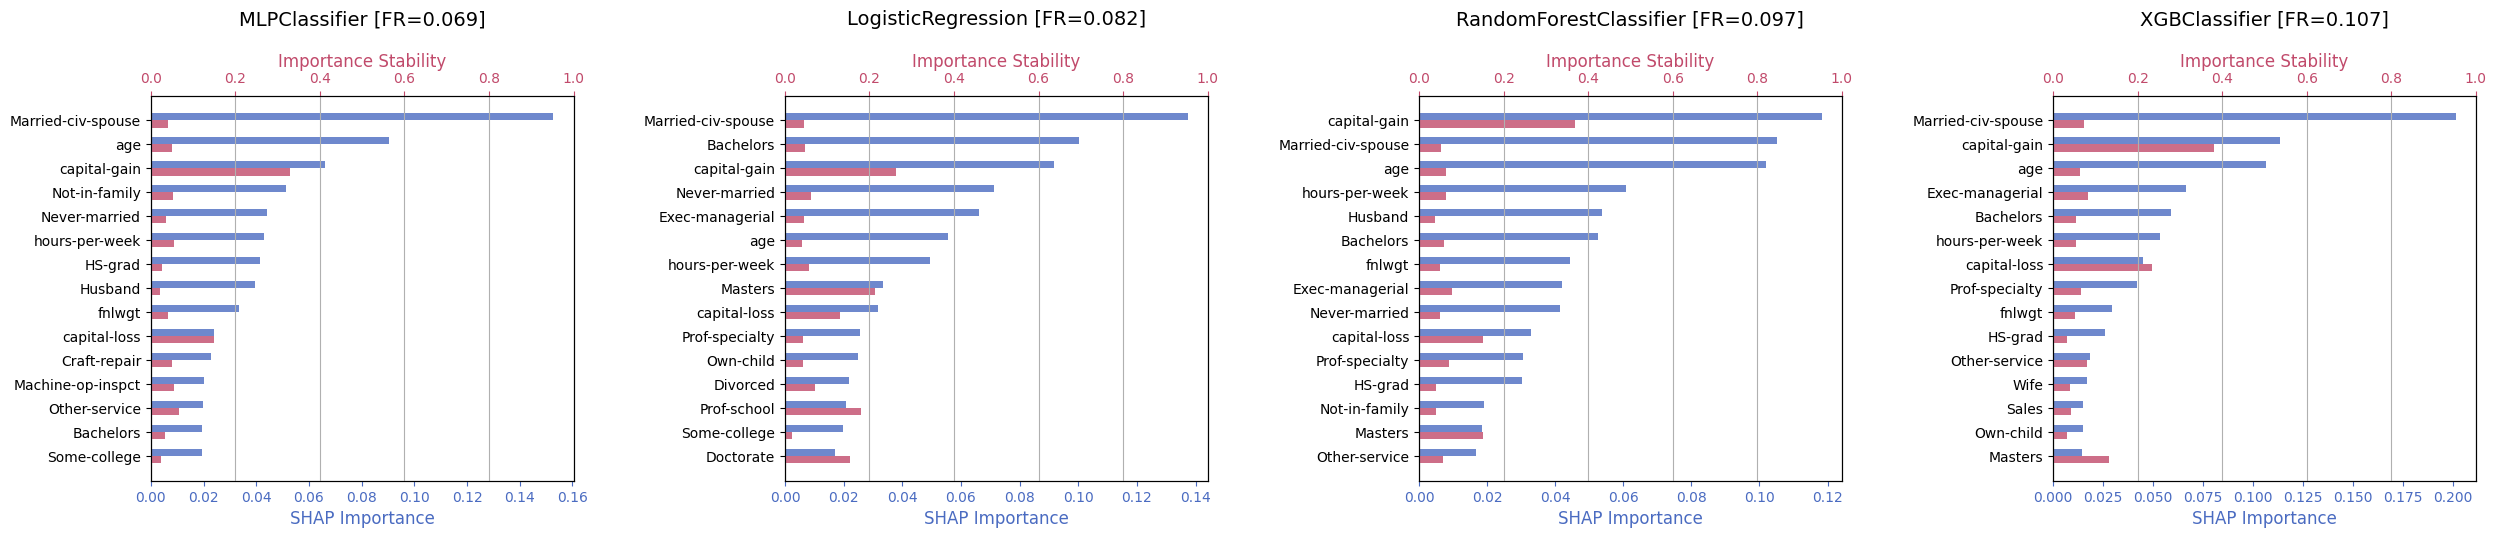

In [14]:
model_names = ['MLPClassifier', 'LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']

plt.figure(figsize=(30, 5))
top_n = 15
for i,model_name in enumerate(model_names):
    plt.subplot(1,4,i+1)
    plot_local_feature_importances_stability(local_results[model_name]['local_importances'], top_n=top_n, model_name=model_name)

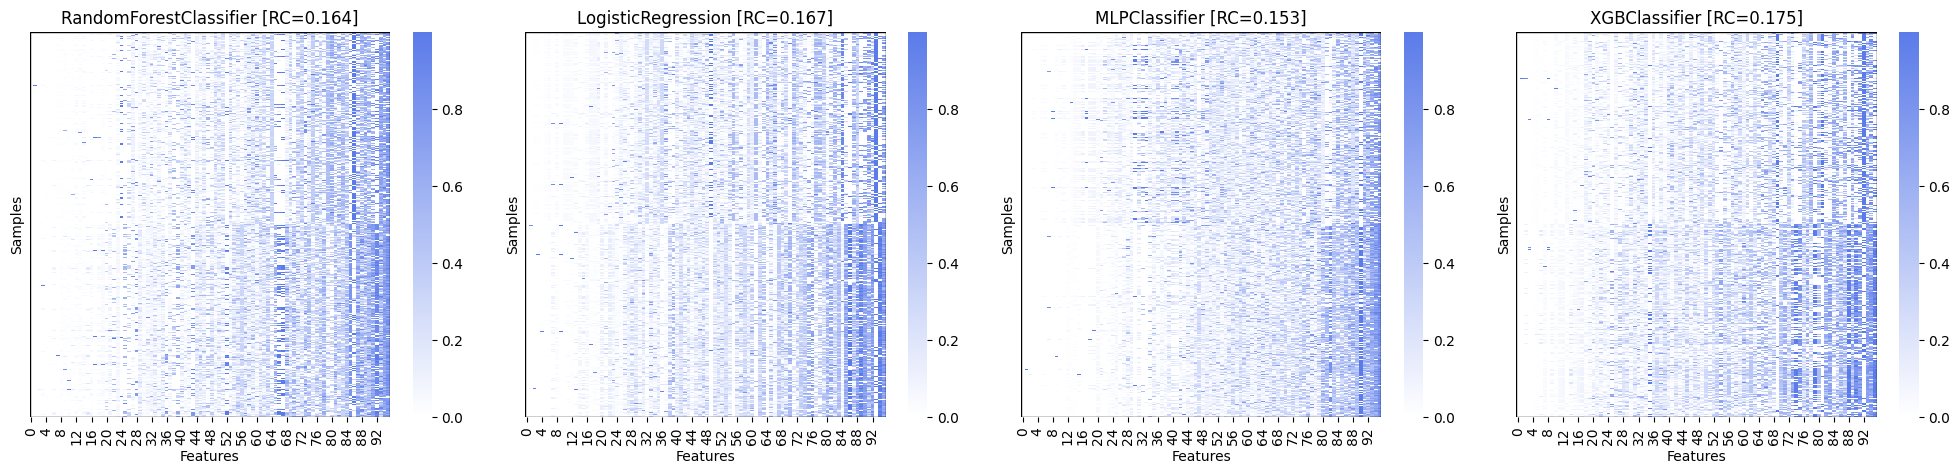

In [16]:
model_names = ['RandomForestClassifier', 'LogisticRegression', 'MLPClassifier', 'XGBClassifier']
plt.figure(figsize=(25, 5))
for i, model_name in enumerate(model_names):
    result = local_results[model_name]
    plt.subplot(1, 4, i+1)
    plot_ranking_consistency(result['local_importances'], model_name)

# Surrogate Model

### Surrogate Analysis - Fetures

In [17]:
surrogates = {}
for model_name,model in models.items():
    y_pred = model.predict(Xt_train)    
    surrogate = create_surrogate_model(Xt_train, y_pred, surrogate_type="shallow_tree")
    surrogates[model_name] = surrogate

### Surrogate Analysis - Metrics

In [18]:
from holisticai.explainability.metrics.surrogate import classification_surrogate_explainability_metrics

metrics = {}
for model_name,surrogate in surrogates.items():
    y_pred = models[model_name].predict(Xt_test)
    metrics[model_name] = classification_surrogate_explainability_metrics(Xt_test, yt_test, y_pred, surrogate)
xai_surrogate_metrics = concatenate_metrics(metrics)

# Merging Results

In [27]:
efficacy_metrics

,RandomForestClassifier,XGBClassifier,LogisticRegression,MLPClassifier,Reference
Metric,,,,,
Accuracy,0.849198,0.874295,0.850083,0.844223,1
Balanced Accuracy,0.769211,0.800881,0.762717,0.765769,1
Precision,0.725174,0.790939,0.740216,0.708290,1
Recall,0.613255,0.657739,0.592374,0.612801,1
F1-Score,0.664535,0.718216,0.658094,0.657094,1


In [28]:
global_metrics

,RandomForestClassifier,XGBClassifier,LogisticRegression,MLPClassifier,Reference,metric_type
Spread Divergence,0.715804,0.749554,0.688843,0.634134,1,global
Fluctuation Ratio,0.076381,0.103488,0.000077,0.009947,0,global
Rank Alignment,0.386128,0.369617,0.496241,0.443333,1,global
Alpha Score,0.125,0.09375,0.135417,0.208333,0,global


In [29]:
xai_surrogate_metrics

,RandomForestClassifier,XGBClassifier,LogisticRegression,MLPClassifier,Reference,metric_type
Accuracy Degradation,0.040784,0.064887,0.039117,0.031662,0,surrogate
Surrogate Fidelity,0.8555,0.876285,0.895301,0.864677,1,surrogate
Surrogate Feature Stability,0.206212,0.23596,0.317172,0.189394,1,surrogate


In [30]:
local_metrics

,RandomForestClassifier,XGBClassifier,LogisticRegression,MLPClassifier,Reference,metric_type
Rank Consistency,0.164316,0.174515,0.1672,0.153106,0,local
Importance Stability,0.09729,0.107428,0.081903,0.068742,0,local


In [33]:
metrics = {'global':global_metrics, 'local':local_metrics, 'surrogate':xai_surrogate_metrics}
dataframes = []
for metric_type,metric in metrics.items():
    metric['metric_type'] = metric_type
    dataframes.append(metric)
df = pd.concat(dataframes, axis=0)
df

,RandomForestClassifier,XGBClassifier,LogisticRegression,MLPClassifier,Reference,metric_type
Spread Divergence,0.715804,0.749554,0.688843,0.634134,1,global
Fluctuation Ratio,0.076381,0.103488,0.000077,0.009947,0,global
Rank Alignment,0.386128,0.369617,0.496241,0.443333,1,global
Alpha Score,0.125,0.09375,0.135417,0.208333,0,global
Rank Consistency,0.164316,0.174515,0.1672,0.153106,0,local
Importance Stability,0.09729,0.107428,0.081903,0.068742,0,local
Accuracy Degradation,0.040784,0.064887,0.039117,0.031662,0,surrogate
Surrogate Fidelity,0.8555,0.876285,0.895301,0.864677,1,surrogate
Surrogate Feature Stability,0.206212,0.23596,0.317172,0.189394,1,surrogate


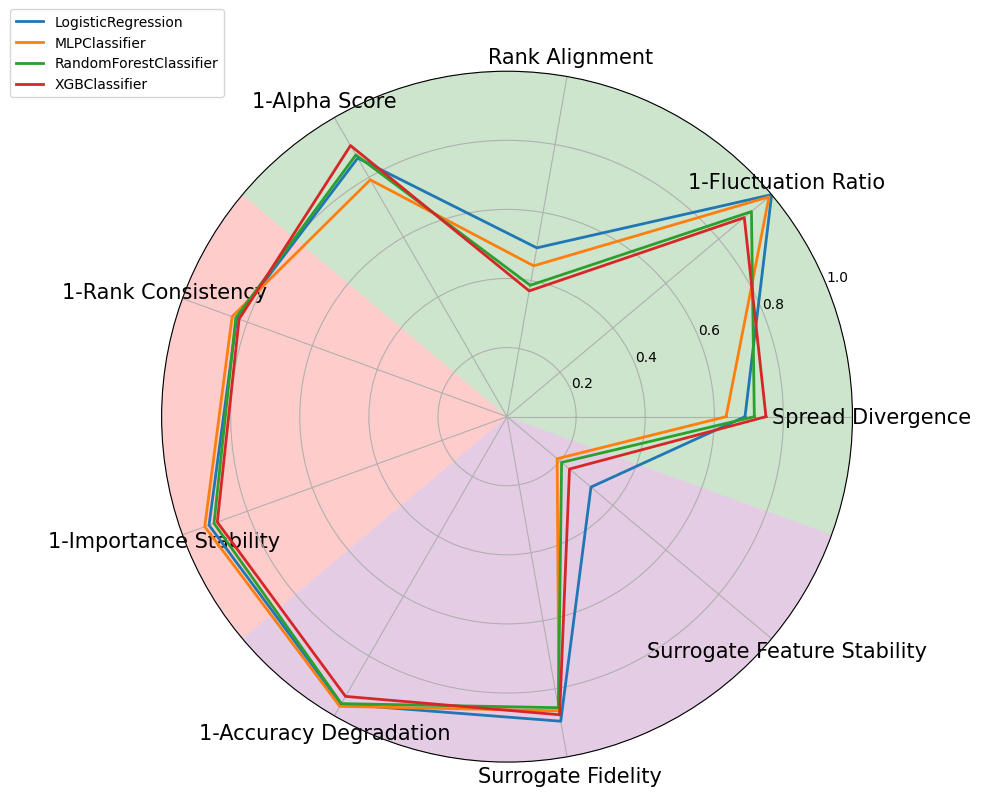

In [32]:
plot_radar_metrics(df, model_names)
plt.show()